# Multi-Modal RAG

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
LANGCHAIN_TRACING_V2 = os.getenv("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = os.getenv("LANGCHAIN_ENDPOINT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")

## Extract the PDF Data

In [2]:
from unstructured.partition.pdf import partition_pdf

output_path = "./data/"
file_path = output_path + '1706.03762v7.pdf'

# Chunk down the pdf into different elements
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            
    strategy="hi_res",

    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,

    chunking_strategy="by_title",      
    max_characters=10000,                 
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)

In [3]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [4]:
chunks[3].metadata.orig_elements

In [5]:
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '8faa0183-71e9-4fa1-8a91-fc7863317774',
 'text': 'Scaled Dot-Product Attention  Multi-Head Attention ',
 'metadata': {'detection_class_prob': 0.8599750995635986,
  'coordinates': {'points': ((410.50833333333327, 197.0675599999999),
    (410.50833333333327, 669.311279296875),
    (1311.755126953125, 669.311279296875),
    (1311.755126953125, 197.0675599999999)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2024-11-24T23:53:58',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVF

In [6]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [7]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

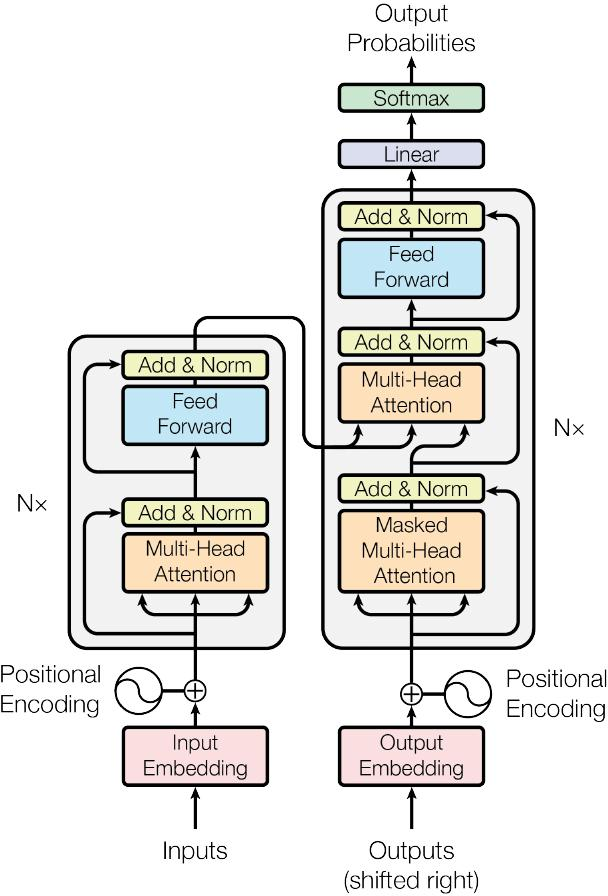

In [8]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarise the Data

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [10]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [11]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [12]:
text_summaries

['A new neural network architecture, the Transformer, based solely on attention mechanisms, is presented.  It outperforms existing models in machine translation tasks, achieving higher BLEU scores and requiring less training time.  The Transformer also generalizes well to other tasks like English constituency parsing.\n',
 'Recurrent neural networks (RNNs) are state-of-the-art for sequence modeling, but their sequential computation limits parallelization.  Attention mechanisms model dependencies without regard to distance, but are typically used with RNNs.  The Transformer architecture eliminates recurrence, relying entirely on attention for global dependencies between input and output, enabling significant parallelization and improved performance.  Other models like the Extended Neural GPU, ByteNet, and ConvS2S also aim to reduce sequential computation using convolutions, but the Transformer achieves constant operations for relating distant positions.  Self-attention, a key component 

In [13]:
table_summaries

[]

In [15]:
import time
prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)
chain = prompt | model | StrOutputParser()

image_summaries = []
for image in images:
    image_summary = chain.invoke([image])
    image_summaries.append(image_summary)
    time.sleep(10)

In [16]:
image_summaries

['The image is a diagram of a Transformer architecture.  It\'s a flow chart showing the sequence of operations within a transformer layer.  There are no bar plots or other numerical data visualizations.\n\nThe diagram shows a layered structure, with each layer containing several components.  These components are depicted as rectangular boxes, with labels indicating their function.  The boxes are in different colors, allowing visual differentiation of the various stages.\n\nThe input to the network is labeled "Inputs".  The first stage is "Positional Encoding" and "Input Embedding".  This is followed by a series of stacked blocks. Each block has the same general structure:\n\n1. **Multi-Head Attention:**  This is represented by a box with the label "Multi-Head Attention" (and "Masked Multi-Head Attention" in a separate layer). This is an important component of the transformer architecture, used for capturing relationships between different parts of the input sequence.\n2. **Add & Norm:*

## Store the data in Vector and Doc stores

In [17]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/Users/varundixit4/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Add texts
if len(texts) > 0:
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    summary_texts = [
        Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
    ]
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
if len(tables) > 0:
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
if len(images) > 0:
    img_ids = [str(uuid.uuid4()) for _ in images]
    summary_img = [
        Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
    ]
    retriever.vectorstore.add_documents(summary_img)
    retriever.docstore.mset(list(zip(img_ids, images)))

In [19]:
# Retrieve
docs = retriever.invoke(
    "who are the authors?"
)

In [20]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna. Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In Advances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurate shift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume 1: Long Papers), pages

In [21]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)

In [22]:
response = chain.invoke(
    "What is the attention mechanism?"
)

In [23]:
print(response)

The attention mechanism is a function that maps a query and a set of key-value pairs to an output.  The output is a weighted sum of the values, where the weights are computed by a compatibility function of the query with the corresponding key.  There are different types of attention, including scaled dot-product attention and multi-head attention.  Multi-head attention uses multiple attention layers in parallel to attend to information from different representation subspaces at different positions.  Scaled dot-product attention computes dot products of queries and keys, divides by the square root of the key dimension, and applies a softmax function to obtain weights.



Response: Multi-head attention is a method that performs the attention function in parallel, using different learned linear projections for queries, keys, and values.  It allows the model to jointly attend to information from different representation subspaces at different positions, which is better than averaging, as done with a single attention head.  The output is the concatenation of the outputs from each head, then projected again.



Context:
3.2.2 Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional

‘To illustrate why the dot products get large, assume that the components of q and k are independent random vari

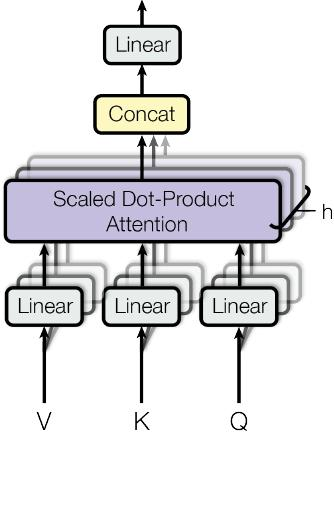

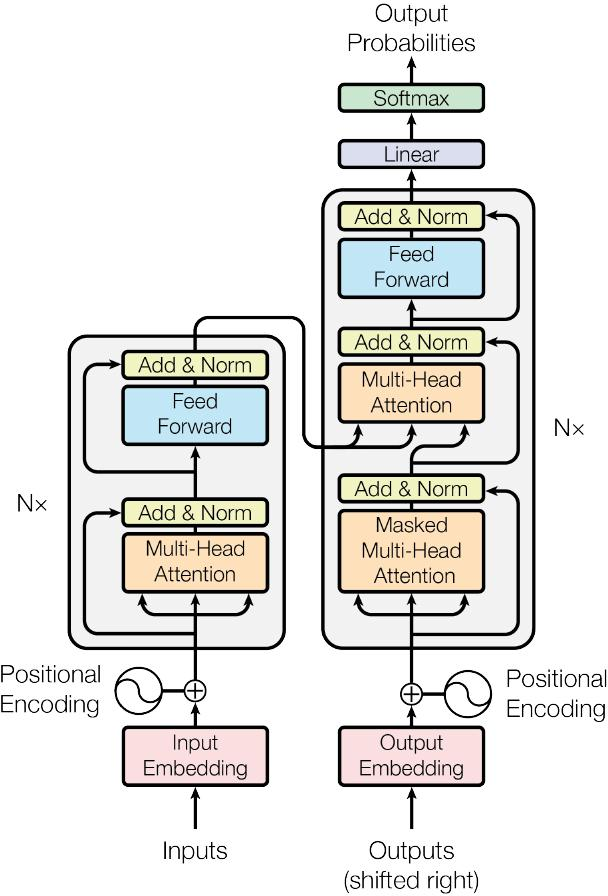

In [24]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)